In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
Dataset=(r'/Users/chiaraciscato/Desktop/geomar/FOCI data/CO2flux_baseline_ensemble1_ssp126_1m.nc')
data = xr.open_dataset(Dataset)
data

<xarray.Dataset>
Dimensions:               (y: 511, x: 722, time_counter: 1020, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2015-01-16T12:00:00 ....
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    co2flux_cpl           (time_counter, y, x) float64 ...
Attributes:
    name:         FOCI2.0-NM004_FM_ESM_SSP126os_2014CC105_1m_20150101_20151231
    description:  diagnostics 2d bio
    title:        diagnostics 2d bio
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2022-Apr-04 13:54:06 CEST
    history:      Wed Jul 13 13:57:37 2022: ncrcat -F -O -L 1 -7 -v co2flux_c...
    NCO:          netCDF Operators version 4.9.1 (Homepage = http://nco.sf.ne...

In [3]:
time = data.variables['time_counter'][:]

In [4]:
y = data.variables['nav_lat'][:]
x = data.variables['nav_lon'][:]
co2flux = data.variables['co2flux_cpl'][:].squeeze()
print(co2flux.shape)

(1020, 511, 722)


In [5]:
x

<xarray.Variable (y: 511, x: 722)>
[368942 values with dtype=float32]
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east

In [6]:
#calculate the month length 
month_length = data.time_counter.dt.days_in_month 
month_length 

<xarray.DataArray 'days_in_month' (time_counter: 1020)>
array([31, 28, 31, ..., 31, 30, 31])
Coordinates:
    time_centered  (time_counter) datetime64[ns] 2015-01-16T12:00:00 ... 2099...
  * time_counter   (time_counter) datetime64[ns] 2015-01-16T12:00:00 ... 2099...

In [7]:
#calculate the weights by grouping by season
weights = (
    month_length.groupby("time_counter.season") / month_length.groupby("time_counter.season").sum()
)
weights

<xarray.DataArray 'days_in_month' (time_counter: 1020)>
array([0.00404119, 0.00365011, 0.00396419, ..., 0.00400776, 0.00387847,
       0.00404119])
Coordinates:
    time_centered  (time_counter) datetime64[ns] 2015-01-16T12:00:00 ... 2099...
  * time_counter   (time_counter) datetime64[ns] 2015-01-16T12:00:00 ... 2099...
    season         (time_counter) <U3 'DJF' 'DJF' 'MAM' ... 'SON' 'SON' 'DJF'

In [8]:
#test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time_counter.season').sum().values, np.ones(4))

In [9]:
data.time_counter

<xarray.DataArray 'time_counter' (time_counter: 1020)>
array(['2015-01-16T12:00:00.000000000', '2015-02-15T00:00:00.000000000',
       '2015-03-16T12:00:00.000000000', ..., '2099-10-16T12:00:00.000000000',
       '2099-11-16T00:00:00.000000000', '2099-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    time_centered  (time_counter) datetime64[ns] 2015-01-16T12:00:00 ... 2099...
  * time_counter   (time_counter) datetime64[ns] 2015-01-16T12:00:00 ... 2099...
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    2015-01-01 00:00:00
    bounds:         time_counter_bounds

In [10]:
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')

True

In [11]:
data = data.set_coords('time_counter')
data

<xarray.Dataset>
Dimensions:               (y: 511, x: 722, time_counter: 1020, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
    time_centered         (time_counter) datetime64[ns] 2015-01-16T12:00:00 ....
  * time_counter          (time_counter) datetime64[ns] 2015-01-16T12:00:00 ....
Dimensions without coordinates: y, x, axis_nbounds
Data variables:
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 2015-01...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] 2015-01...
    co2flux_cpl           (time_counter, y, x) float64 ...
Attributes:
    name:         FOCI2.0-NM004_FM_ESM_SSP126os_2014CC105_1m_20150101_20151231
    description:  diagnostics 2d bio
    title:        diagnostics 2d bio
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2022-Apr-04 13:54:06 CEST
    history:      Wed Jul 13 13:57:37 2022: ncrcat -F -O -L 1 -7 -v co2flux_c...
    NCO:          netCDF Operators version 4.9.1 (Homepage = http://nco.sf.ne...

In [44]:
data_weighted = (time * weights).groupby("time_counter.season").sum(dim="time_counter")
data_weighted

UFuncTypeError: ufunc 'multiply' cannot use operands with types dtype('<M8[ns]') and dtype('float64')

In [13]:
#Divide the dataframe by seasons
DS_season = data.groupby('time_counter.season').mean('time_counter')
DS_season

<xarray.Dataset>
Dimensions:      (y: 511, x: 722, season: 4)
Coordinates:
    nav_lat      (y, x) float32 -77.01 -77.01 -77.01 -77.01 ... 50.07 50.0 50.0
    nav_lon      (y, x) float32 72.75 73.25 73.75 74.25 ... 73.01 73.0 73.0
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: y, x
Data variables:
    co2flux_cpl  (season, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [47]:
#Select winter
DS_winter = DS_season.sel(season='DJF')
DS_winter

<xarray.Dataset>
Dimensions:      (y: 511, x: 722)
Coordinates:
    nav_lat      (y, x) float32 -77.01 -77.01 -77.01 -77.01 ... 50.07 50.0 50.0
    nav_lon      (y, x) float32 72.75 73.25 73.75 74.25 ... 73.01 73.0 73.0
    season       <U3 'DJF'
Dimensions without coordinates: y, x
Data variables:
    co2flux_cpl  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [48]:
#Select summer 
DS_summer = DS_season.sel(season='JJA')
DS_summer

<xarray.Dataset>
Dimensions:      (y: 511, x: 722)
Coordinates:
    nav_lat      (y, x) float32 -77.01 -77.01 -77.01 -77.01 ... 50.07 50.0 50.0
    nav_lon      (y, x) float32 72.75 73.25 73.75 74.25 ... 73.01 73.0 73.0
    season       <U3 'JJA'
Dimensions without coordinates: y, x
Data variables:
    co2flux_cpl  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [48]:
#Flatten coordinates into 1D and round to x decimals 

data['nav_lon'] = data['nav_lon'].values.flatten()
data['nav_lat'] = data['nav_lat'].values.flatten()

data['nav_lon'] = data['nav_lon'].round(decimals = 0)
data['nav_lat'] = data['nav_lat'].round(decimals = 0)

In [49]:
data.nav_lat

<xarray.DataArray 'nav_lat' (nav_lat: 368942)>
array([-77., -77., -77., ...,  50.,  50.,  50.], dtype=float32)
Coordinates:
  * nav_lat  (nav_lat) float32 -77.0 -77.0 -77.0 -77.0 ... 50.0 50.0 50.0 50.0

In [33]:
DS_Season = data.sel(nav_lon=slice(*lon_bnd), nav_lat=slice(*lat_bnd),).co2flux.groupby('time_counter.season').mean('time_counter')

KeyError: 'Cannot get left slice bound for non-unique label: 25'

In [27]:
data['nav_lon'] = data['nav_lon'].values.flatten()
data['nav_lat'] = data['nav_lat'].values.flatten()

Text(0.5, 1.02, 'CO2 flux')

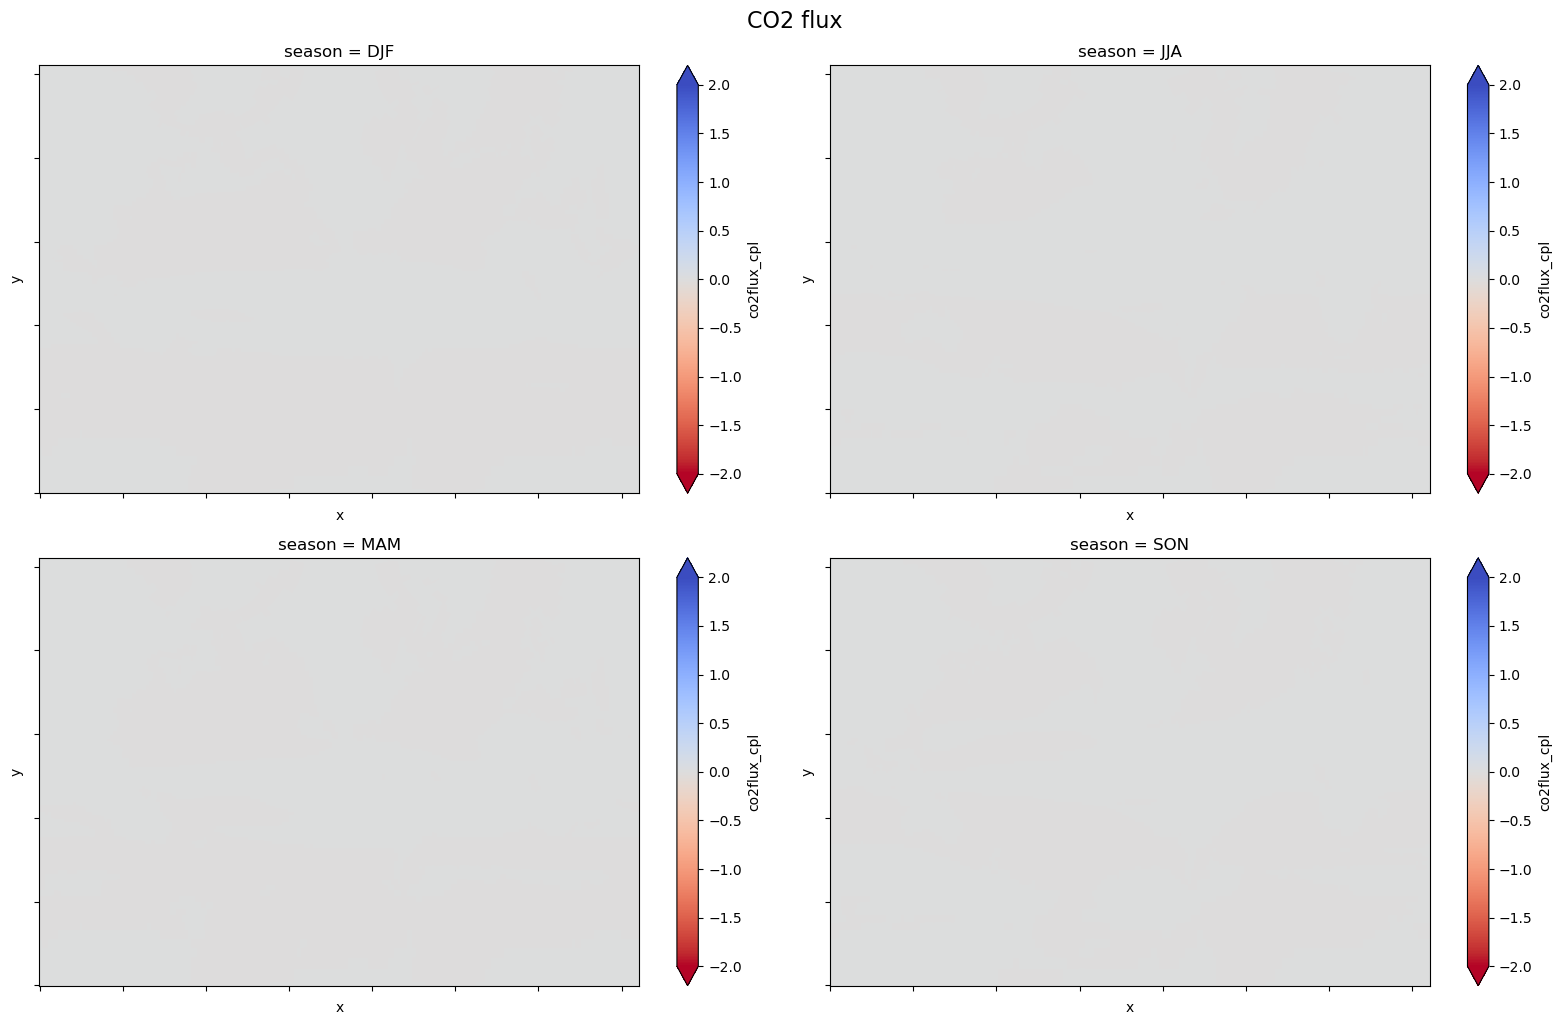

In [32]:
DS_Season = data.co2flux_cpl.groupby('time_counter.season').mean('time_counter')

DS_Season = data.co2flux_cpl.groupby('time_counter.season').mean('time_counter')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
nav_lat = 0
for nav_lon, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if season =='JJA':
        nav_lat += 1
        nav_lon = 0
    elif season =='SON':
        nav_lon = 1
        
    DS_Season.sel(season=season).plot.pcolormesh(
        ax=axes[nav_lon, nav_lat], vmin=-2, vmax=2, cmap='coolwarm_r',
        add_colorbar=True, extend='both')
    
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
   
plt.tight_layout()
fig.suptitle('CO2 flux', fontsize=16, y=1.02)

In [39]:
data.sel(nav_lat=(data.nav_lat < 36) | (data.nav_lat > 68))
data.sel(nav_lon=(data.nav_lon < -22) | (data.nav_lon > 28))
area = data.sel(nav_lon=slice(*lon_bnd), nav_lat=slice(*lat_bnd),)
area

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

/opt/anaconda3/envs/GEOMAR/lib/python3.7/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


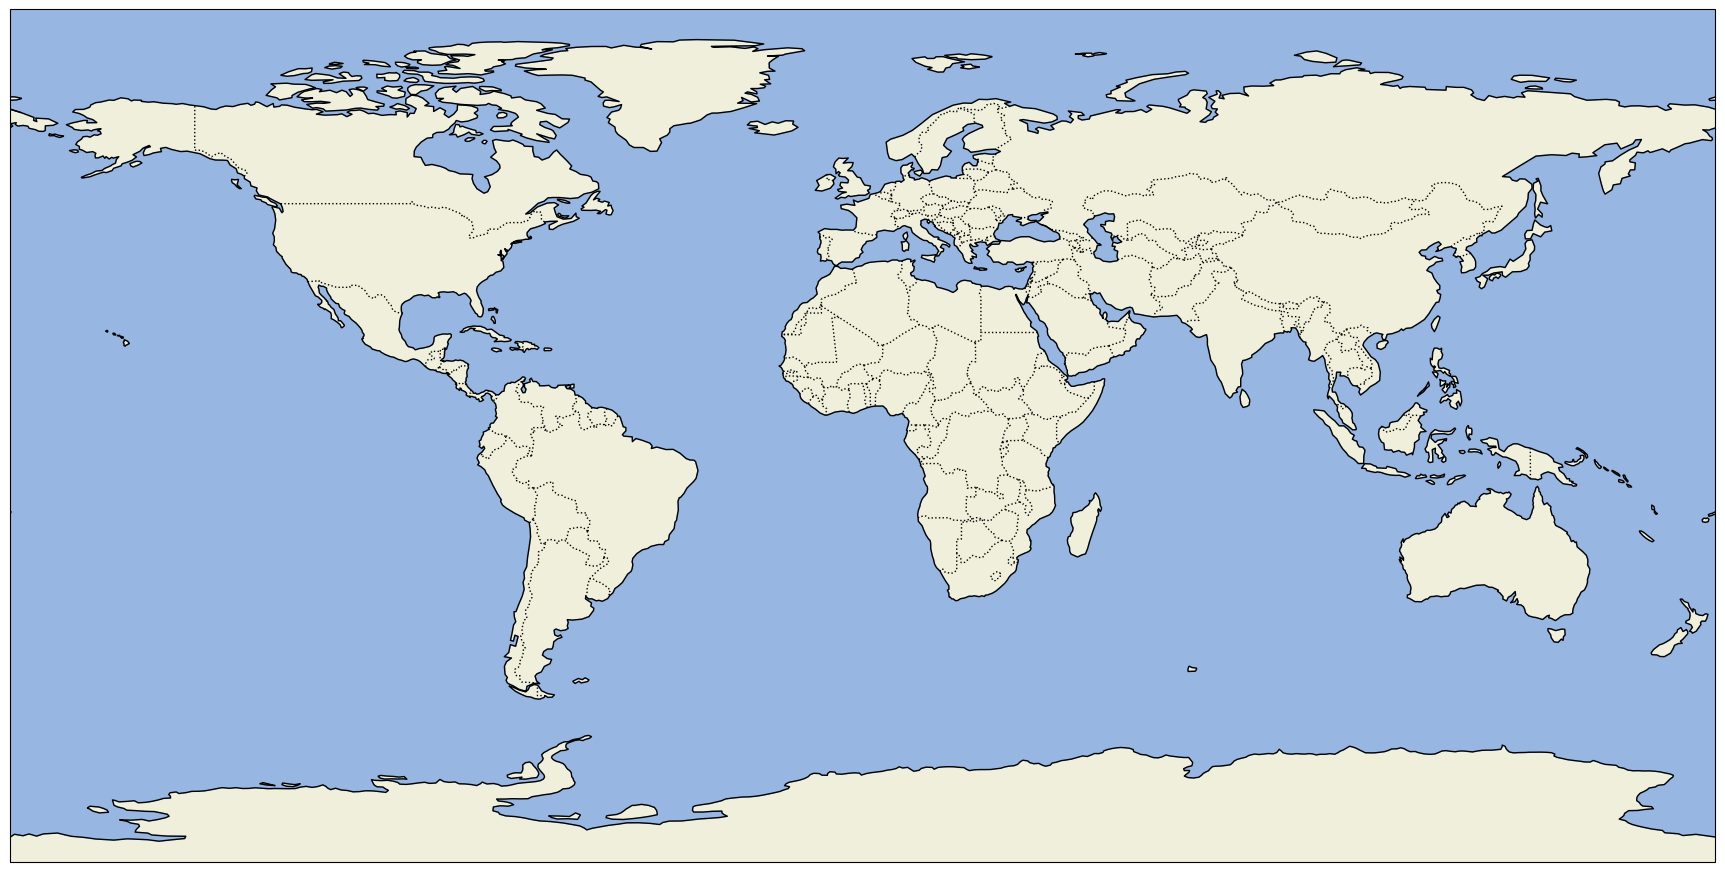

In [42]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat
def make_figure():
    fig = plt.figure(figsize=(22, 12))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # generate a basemap with country borders, oceans and coastlines
    ax.add_feature(cfeat.LAND)
    ax.add_feature(cfeat.OCEAN)
    ax.add_feature(cfeat.COASTLINE)
    ax.add_feature(cfeat.BORDERS, linestyle='dotted')
    return fig, ax

make_figure();

IndexError: index -1 is out of bounds for axis 0 with size 0

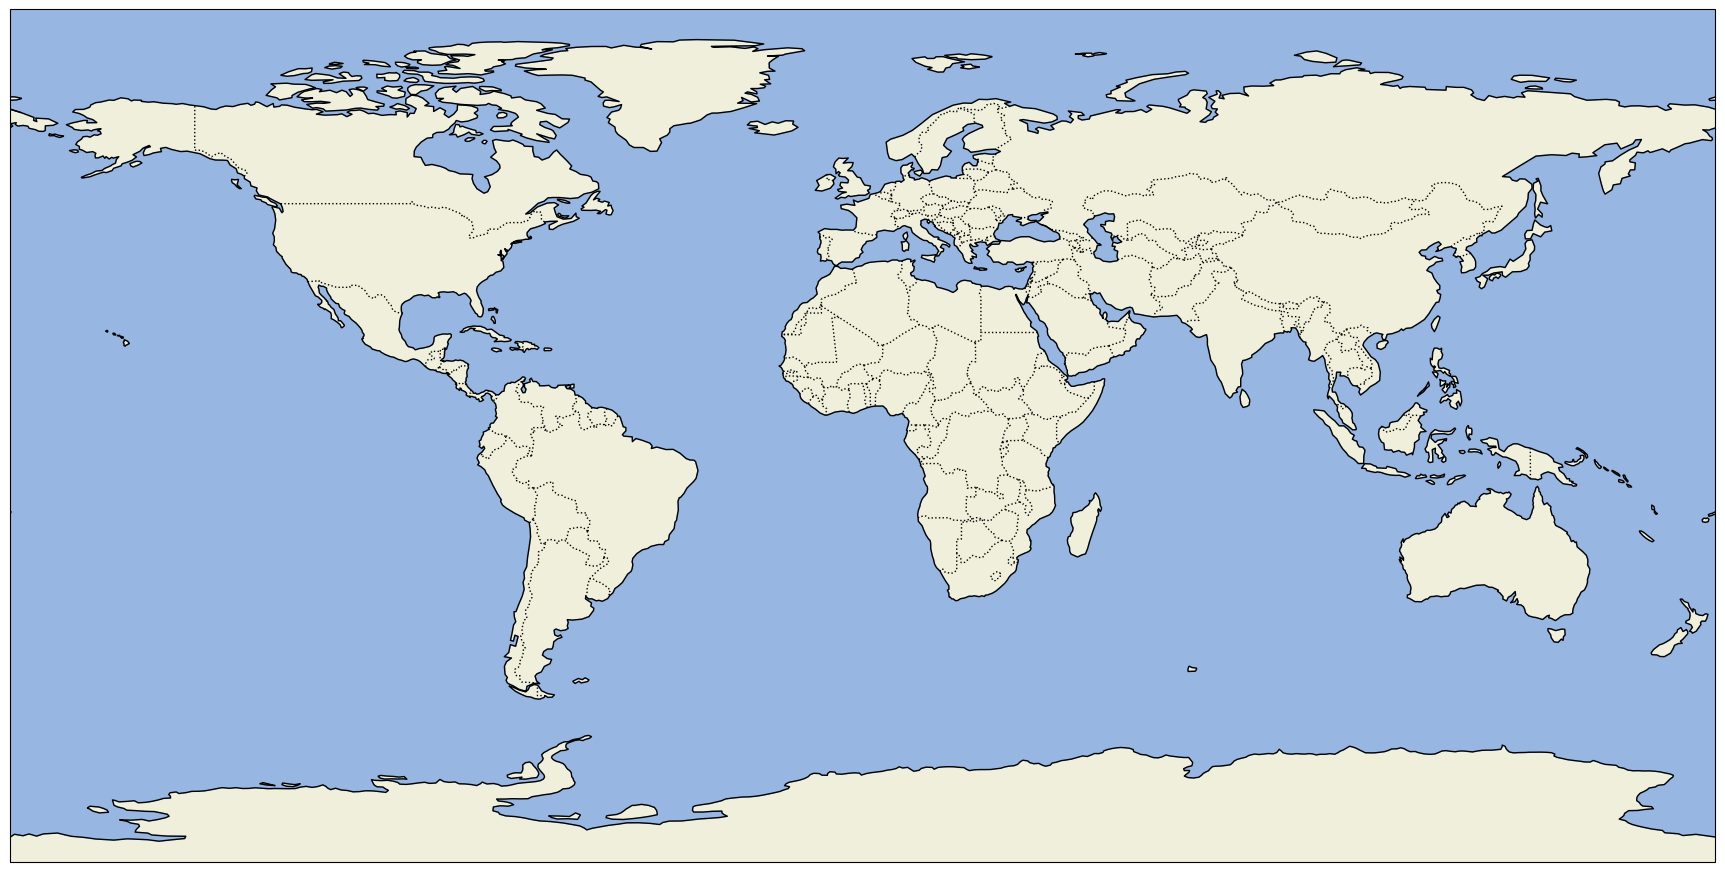

In [43]:
_, ax = make_figure()
# plot the temperature field
area.co2flux_cpl[500].plot()